In [1]:
import torch 
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
#make_moons 用于生成具有两个互连月牙形状的二维数据集

In [2]:

class Flow(nn.Module):
    '''
    - dim:输入的维度
    - h:隐藏层的维度
    '''
    #dim+1  to  dim的NN
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        '''
        将输入的t和x_t连接起来，通过神经网络得到导数值
        '''
        # 沿着最后一个维度进行拼接
        return self.net(torch.cat((t, x_t), -1))
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        #t_start:[batch_size,1]
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        # For simplicity, using midpoint ODE solver in this example
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

forward 方法本质上是在学习一个连续时间的向量场（vector field），它告诉我们在任意时间点和任意状态下，系统应该如何变化（即导数应该是多少）。这个学习到的向量场就是用来指导从简单分布（如高斯分布）逐渐变换到复杂目标分布（如月牙形状分布）的过程

ODE（常微分方程）求解器的一般形式用于数值求解形如 $\frac{dx(t)}{dt} = f(t, x(t))$ 的方程。根据你的代码片段，`Flow` 类中的 `step` 方法实现了一个简单的中点法 ODE 求解器。下面是几种常见的 ODE 求解器的形式：

### 1. **欧拉法 (Euler Method)**
这是最简单的 ODE 求解方法之一，适用于一阶 ODE。

$x_{n+1} = x_n + h \cdot f(t_n, x_n)$


其中：
- $x_n$ 是在时间 $t_n$ 的状态。
- $h$ 是时间步长。
- $f(t_n, x_n)$ 是 ODE 的右侧函数，在时间 $t_n$ 和状态 $x_n$ 下的导数。



### 2. **中点法 (Midpoint Method)**
中点法是一种改进的欧拉法，提高了精度。

$x_{n+1} = x_n + h \cdot f\left(t_n + \frac{h}{2}, x_n + \frac{h}{2} \cdot f(t_n, x_n)\right)$

这与你在 `step` 方法中实现的方式相似：

```python
def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
    t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
    h = t_end - t_start
    t_mid = t_start + h / 2
    x_mid = x_t + self(x_t=x_t, t=t_start) * h / 2
    return x_t + h * self(t=t_mid, x_t=x_mid)
```



### 3. **龙格-库塔法 (Runge-Kutta Methods)**
特别是四阶龙格-库塔法 (RK4)，它是一个常用的高精度 ODE 求解器。

$$
\begin{align}
k_1 &= h \cdot f(t_n, x_n) \\
k_2 &= h \cdot f\left(t_n + \frac{h}{2}, x_n + \frac{k_1}{2}\right) \\
k_3 &= h \cdot f\left(t_n + \frac{h}{2}, x_n + \frac{k_2}{2}\right) \\
k_4 &= h \cdot f(t_n + h, x_n + k_3) \\
x_{n+1} &= x_n + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{align}
$$



### 4. **隐式方法 (Implicit Methods)**
例如后向欧拉法 (Backward Euler Method)，适用于刚性 ODE。

$x_{n+1} = x_n + h \cdot f(t_{n+1}, x_{n+1}) $

这类方法通常需要迭代求解，因为 $x_{n+1}$ 同时出现在等式的两边。
- $x_n$ 是在时间 $t_n$的状态。
- $h$ 是时间步长。
- $ f(t_{n+1}, x_{n+1}) $ 是 ODE 的右侧函数，在时间 $t_{n+1}$ 和状态 $x_{n+1}$ 下的导数。
### 总结
你实现的 `step` 方法使用了中点法来近似求解 ODE。中点法通过在中间时间点计算导数，从而提高了精度，相比于简单的欧拉法有更好的稳定性。如果你需要更高的精度或处理更复杂的 ODE 系统，可以考虑使用更高阶的方法，如四阶龙格-库塔法。

# Training

In [10]:
import swanlab


flow = Flow()
optimizer = torch.optim.AdamW(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()
config={
    "optimizer": "AdamW",
    "learning_rate": 1e-2,
    "loss_fn": "MSELoss",
    "batch_size": 256,
    "epochs": 30000
}
swanlab.login(api_key="IuMJIQvmJuslgb8YiTXSr")
# 创建 SwanLab 实验
experiment = swanlab.init(
    project_name="flow_matching",
    experiment_name="moon_distribution_5",
    config=config
)

for epoch in range(30000):
    # make_moons分布
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    #高斯分布
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss = loss_fn(flow(t=t, x_t=x_t), dx_t)
    loss.backward()
    optimizer.step()
    
    # 记录训练损失
    experiment.log({
        'epoch': epoch,
        'loss': loss.item()
    })

# 完成实验
experiment.finish()

swanlab: swanlab version 0.5.8 is available!  Upgrade: `pip install -U swanlab`    
swanlab: Tracking run with swanlab version 0.4.8                                   
swanlab: Run data will be saved locally in c:\Users\Lenovo\Desktop\Paper-recover\Flow_matching\flow_matching-main\examples\swanlog\run-20250521_193001-ee278795
swanlab: 👋 Hi offline888, welcome to swanlab!
swanlab: Syncing run moon_distribution_5 to the cloud
swanlab: 🌟 Run `swanlab watch c:\Users\Lenovo\Desktop\Paper-recover\Flow_matching\flow_matching-main\examples\swanlog` to view SwanLab Experiment Dashboard locally
swanlab: 🏠 View project at https://swanlab.cn/@offline888/examples
swanlab: 🚀 View run at https://swanlab.cn/@offline888/examples/runs/arrvvh4sobvj1j7kicw86


swanlab: 🌟 Run `swanlab watch c:\Users\Lenovo\Desktop\Paper-recover\Flow_matching\flow_matching-main\examples\swanlog` to view SwanLab Experiment Dashboard locally
swanlab: 🏠 View project at https://swanlab.cn/@offline888/examples
swanlab: 🚀 View run at https://swanlab.cn/@offline888/examples/runs/arrvvh4sobvj1j7kicw86


# Sampling

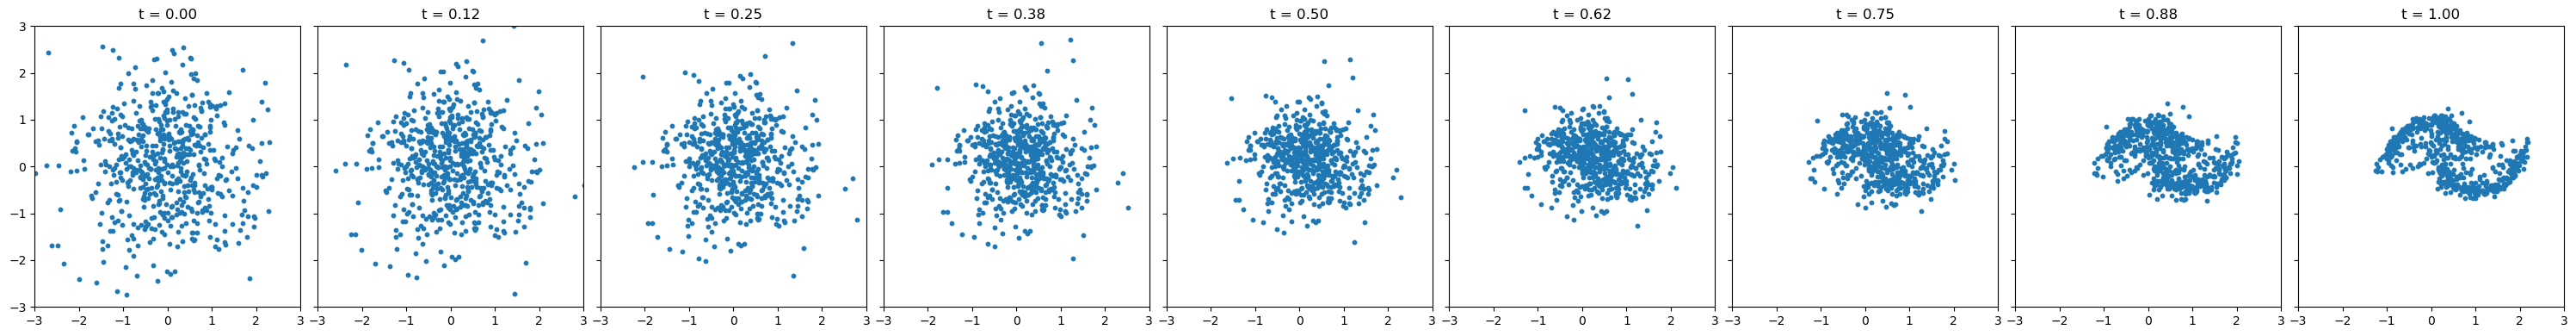

In [14]:
torch.manual_seed(0)
#生成300个二维高斯分布的点
x = torch.randn(600, 2)
#设置变换的步数
n_steps = 8
#走8步需要9个图
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
#创建均匀分布的时间步数
time_steps = torch.linspace(0, 1.0, n_steps + 1)

#绘制原始数据图
#scatter() 是 matplotlib 的散点图绘制函数
#第一个参数是 x 坐标，第二个参数是 y 坐标
#s=10 设置点的大小为 10
axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
#设置标题显示时间
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    #使用flow.step进行一步变换，从time_steps[i]到time_steps[i+1]
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()